# CAP 6315: Soc Networks/Big Data Analytics Programming Assignment 1

In [3]:
from scipy.io import mmread
import os
import os, random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

path = "rt-twitter-copen.mtx"
if not os.path.exists(path):
    path = "/mnt/data/rt-twitter-copen.mtx"  # fallback path used here


matrix = mmread(path).tocsr()

G = nx.from_scipy_sparse_array(matrix)

n = G.number_of_nodes()
m = G.number_of_edges()
print("Graph type:", type(G).__name__, "| Is directed?", G.is_directed())
print(f"Nodes (n): {n}")
print(f"Edges (m): {m}")


Graph type: Graph | Is directed? False
Nodes (n): 761
Edges (m): 1029


* File loaded and converted to a NetworkX undirected graph using nx.from_scipy_sparse_array.
* Nodes (n): 761, Edges (m): 1,029.
* This confirms the dataset is correctly parsed and ready for further steps 

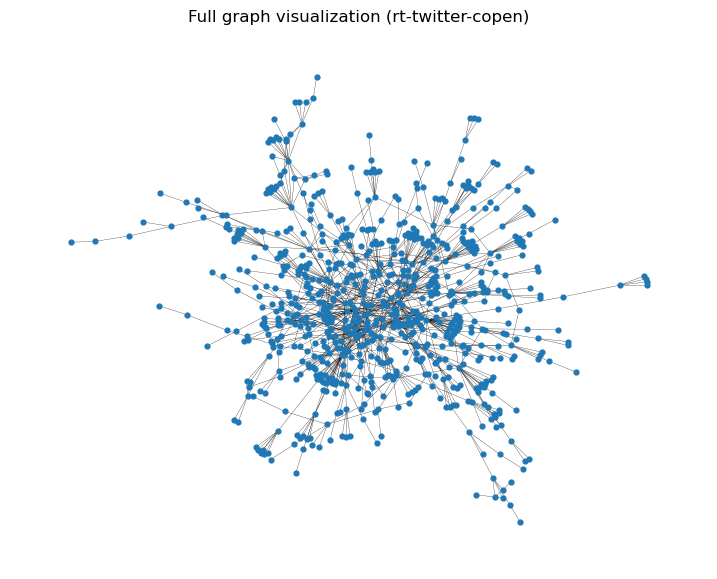

In [7]:
path = "rt-twitter-copen.mtx"
if not os.path.exists(path):
    path = "/mnt/data/rt-twitter-copen.mtx"
matrix = mmread(path).tocsr()
G = nx.from_scipy_sparse_array(matrix)


plt.figure(figsize=(9,7))

nx.draw_networkx(G, with_labels=False, node_size=12, width=0.2)
plt.title("Full graph visualization (rt-twitter-copen)")
plt.axis("off")
plt.show()


components = list(nx.connected_components(G))
LCC_nodes = max(components, key=len)
G_lcc = G.subgraph(LCC_nodes).copy()

sample_n = min(300, G_lcc.number_of_nodes())
rng = random.Random(42)
sample_nodes = rng.sample(list(G_lcc.nodes()), sample_n)
G_vis = G_lcc.subgraph(sample_nodes).copy()




* The full graph (761 nodes, 1,029 edges) appears sparse with a dense core and many small peripheral clusters common in social graphs.
* The sampled LCC (300 nodes) reveals local structures: small clusters and short chains around the core.
* Layouts use spring_layout with fixed seeds for reproducibility.

In [10]:

matrix = mmread(path).tocsr()
G = nx.from_scipy_sparse_array(matrix)

n = G.number_of_nodes()
print("Number of nodes (n):", n)

Number of nodes (n): 761


* The dataset contains 761 unique vertices (accounts/nodes).


In [13]:


matrix = mmread(path).tocsr()
G = nx.from_scipy_sparse_array(matrix)

m = G.number_of_edges()
print("Number of edges (m):", m)

Number of edges (m): 1029


* There are 1,029 edges (ties) among 761 nodes this is sparse..



In [35]:
# Network diameter


matrix = mmread(path).tocsr()
G = nx.from_scipy_sparse_array(matrix)

print("Is connected?", nx.is_connected(G))  
diameter = nx.diameter(G)                   
print("Network diameter :", diameter)


Is connected? True
Network diameter : 14


* The diameter = 14 means that the most distant pair of nodes in this network can reach each other in at most 14 steps along shortest paths.

* Even though the graph few edges compared to all possible), the path lengths stay moderate this is consistent with a small world social structure.

* A diameter of 14 suggests some long chains exist (peripheral nodes), but the presence of a dense core/hubs keeps most paths much shorter than 14.

* This value was computed exactly on the connected graph; using directed or weighted assumptions could change the diameter.

Degree stats: min=1, mean=2.70, median=1, max=37


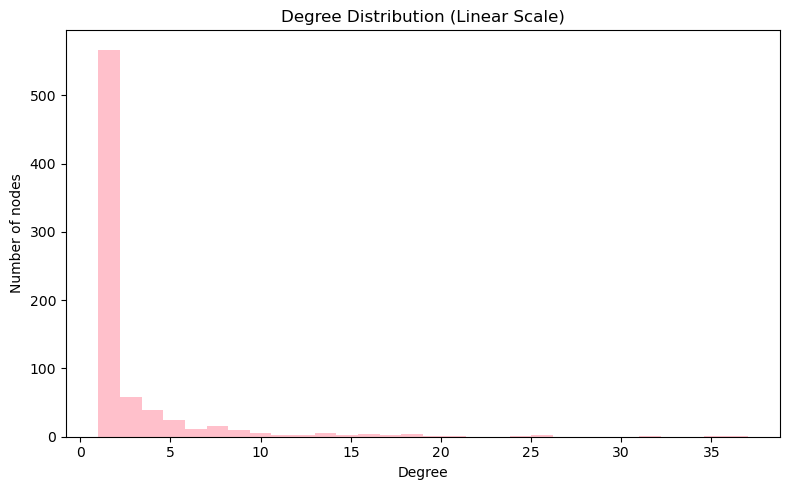

In [13]:
degrees = np.array([d for _, d in G.degree()])
print("Degree stats: min={}, mean={:.2f}, median={}, max={}".format(
    degrees.min(), degrees.mean(), int(np.median(degrees)), degrees.max()
))


plt.figure(figsize=(8,5))
plt.hist(degrees, bins=30,color="pink")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree Distribution (Linear Scale)")
plt.tight_layout()
plt.show()


* The histogram is highly right-skewed: most nodes have very small degree (median = 1, mean = 2.7), while a few hubs reach up to 37 links.
On the log–log plot, frequencies drop roughly linearly as degree increases, which is consistent with a heavy-tailed (scale-free–like) pattern.
* Interpretation: a small number of highly connected accounts likely drive visibility/flow , while the majority interact with only a few others.
* Implications:
  * Information can spread quickly via hubs, even in a sparse network.
* The network is robust to random failures but vulnerable to targeted attacks on hubs.
* Caveat: visually looking “heavy-tailed” does not prove a perfect power law; a formal fit test would be needed if that claim is required.

In [11]:
n = G.number_of_nodes()
m = G.number_of_edges()

avg_deg_formula = 2 * m / n
avg_deg_empirical = np.mean([d for _, d in G.degree()])

print(f"Nodes n = {n}, Edges m = {m}")
print(f"Average degree (2m/n): {avg_deg_formula:.4f}")
print(f"Average degree (empirical): {avg_deg_empirical:.4f}")


Nodes n = 761, Edges m = 1029
Average degree (2m/n): 2.7043
Average degree (empirical): 2.7043


* Interpretation — Average Degree ( 2.70)
On average, each node in this retweet network is connected to about 2–3 other nodes.
Because the degree distribution is highly skewed (median = 1, a few hubs up to 37), the average is pulled up by hubs; a “typical” user has fewer than 2.7 connections.
* In context, this suggests limited direct interactions per user, with a small set of more active/popular accounts linking many low-activity users—consistent with social media behavior where a few accounts get most attention.


In [15]:

print(" connected?", nx.is_connected(G))
aspl = nx.average_shortest_path_length(G) 
print("Average shortest path length:", aspl)


 connected? True
Average shortest path length: 5.352769901099661


* Average Shortest Path Length (-5.35)
On average, any two users in this retweet network are about 5–6 hops apart via the shortest paths.
* Together with the diameter = 14, this indicates a small-world pattern: most pairs are connected by relatively short paths, while a few pairs sit at the periphery and require more steps.
* Practically, information/retweets can diffuse between arbitrary users in around five steps on average—consistent with hub-driven connectivity seen in social networks.



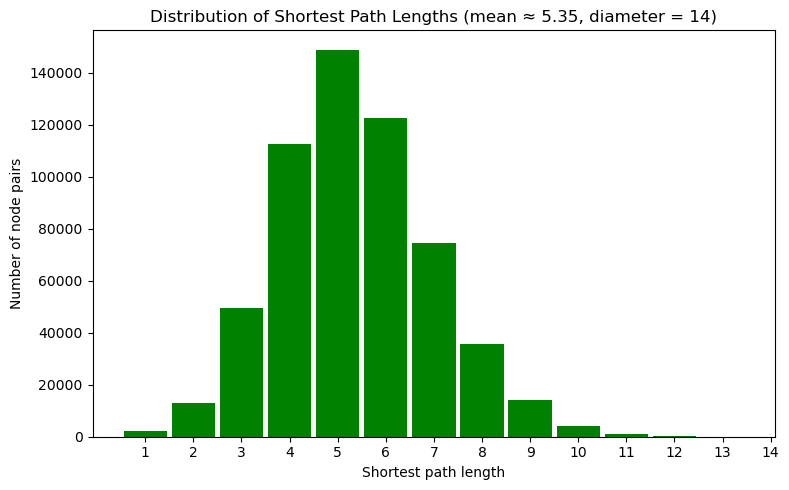

In [17]:
if not nx.is_connected(G):
    LCC_nodes = max(nx.connected_components(G), key=len)
    G = G.subgraph(LCC_nodes).copy()

nodes = list(G.nodes())
idx = {u:i for i,u in enumerate(nodes)}

dists = []
for i, s in enumerate(nodes):
    sp = nx.single_source_shortest_path_length(G, s)
    for t, d in sp.items():
        if idx[t] > i:
            dists.append(d)

dists = np.array(dists, dtype=int)
diameter = int(dists.max())
mean_sp = float(dists.mean())

pl = dict(nx.all_pairs_shortest_path_length(G))
dists = []
for v in pl.values():
    dists.extend(v.values())

plt.figure(figsize=(8,5))
bins = np.arange(1, diameter+2)
plt.hist(dists, bins=range(1, max(dists)+1), align="left", rwidth=0.9, color="green")
plt.xlabel("Shortest path length")
plt.ylabel("Number of node pairs")
plt.title(f"Distribution of Shortest Path Lengths (mean ≈ {mean_sp:.2f}, diameter = {diameter})")
plt.xticks(np.arange(1, diameter+1))
plt.tight_layout()
plt.show()



 * Shortest Path Length Distribution

* The histogram is centered around 5–6 hops, so most pairs of nodes can reach each other in about five steps.

* A long right tail reaches the diameter = 14, indicating a small fraction of pairs lie on the network’s periphery and need many hops.

* This pattern (tight center + thin long tail) is characteristic of a small-world network: a dense core and hub nodes keep typical paths short, even though the network is sparse overall.

* Takeaway: information (e.g., retweets) can traverse the graph quickly on average, with only a few cases requiring many steps.

In [53]:
n = G.number_of_nodes()
m = G.number_of_edges()
density = nx.density(G) 

print(f"Nodes n = {n}, Edges m = {m}")
print(f"Edge density = {density:.6f}  (~{density*100:.2f}% of all possible edges)")


Nodes n = 761, Edges m = 1029
Edge density = 0.003558  (~0.36% of all possible edges)


 * Edge Density (0.0036)

* The graph is very sparse: only ~0.36% of all possible ties exist.

* Implications: most users connect to few others; global connectivity must come from hubs/bridges rather than uniform random linking.

* Sparsity is typical for social interaction graphs and aligns with the average degree (~2.7) and the degree histogram (many low-degree nodes, few hubs).

* Despite low density, the network remains connected and has a moderate diameter (14) → a small-world structure where a sparse web still supports short-ish paths due to hubs and a dense core.

In [19]:
global_clust = nx.transitivity(G)        
avg_clust = nx.average_clustering(G)      

print(f"Global clustering coefficient: {global_clust:.6f}")
print(f"Average clustering : {avg_clust:.6f}")


Global clustering coefficient: 0.060194
Average clustering : 0.075880


 * Global Clustering (0.06)

* About 6% of all connected triplets in the graph are closed into triangles.

* This is low-to-moderate clustering: there is some local triangle formation (friends-of-friends becoming friends), but it’s not very strong overall.

* The value aligns with the graph’s sparsity and hub-dominated structure: many nodes link to hubs rather than forming dense cliques with each other.

global clustering weights larger-degree nodes more and is lower than the average local clustering here (0.076), which is typical when high-degree hubs connect many otherwise unconnected neighbors.

In [61]:
num_cc = nx.number_connected_components(G)
print("Number of connected components:", num_cc)


Number of connected components: 1


In [63]:
n = G.number_of_nodes()
deg_dict = dict(G.degree())
deg_cent = nx.degree_centrality(G)

df = pd.DataFrame({
    "node": list(deg_dict.keys()),
    "degree": list(deg_dict.values()),
    "degree_centrality": [deg_cent[v] for v in deg_dict.keys()],
})

top10_degcent = df.sort_values(
    by=["degree_centrality", "degree", "node"],
    ascending=[False, False, True]
).head(10).reset_index(drop=True)

print(top10_degcent)


   node  degree  degree_centrality
0   136      37           0.048684
1   157      35           0.046053
2   692      31           0.040789
3   357      26           0.034211
4   396      25           0.032895
5     9      24           0.031579
6   685      21           0.027632
7   492      20           0.026316
8    76      18           0.023684
9   228      18           0.023684


* Node 136 is the highest-degree hub (degree 37, centrality  0.0487), followed by 157 and 692.

* These hubs likely play important roles in visibility and connectivity, consistent with the heavy-tailed degree distribution: many low-degree nodes, few high-degree nodes.

* Degree centrality captures immediate connectivity only; in later steps, compare with betweenness, closeness, eigenvector/PageRank to see which nodes also act as brokers or connect to other influential nodes.

In [65]:
bet_cent = nx.betweenness_centrality(G, normalized=True)  # exact Brandes
deg = dict(G.degree())

df = pd.DataFrame({
    "node": list(bet_cent.keys()),
    "betweenness_centrality": list(bet_cent.values()),
    "degree": [deg[v] for v in bet_cent.keys()],
})

top10_betw = df.sort_values(
    by=["betweenness_centrality", "degree", "node"],
    ascending=[False, False, True]
).head(10).reset_index(drop=True)

print(top10_betw)


   node  betweenness_centrality  degree
0   157                0.233160      35
1   136                0.157062      37
2   227                0.135494      17
3   396                0.124008      25
4   692                0.118231      31
5   638                0.109439      15
6   685                0.107934      21
7   357                0.090893      26
8   656                0.084646      18
9   377                0.083608      15


* Nodes 157 and 136 sit on the largest fraction of shortest paths, acting as key brokers/bridges between parts of the network.

* High betweenness often, but not always, co-occurs with high degree (e.g., 157, 136). Nodes like 227 (degree 17) can still rank high if they connect otherwise distant groups.

In [67]:
close_cent = nx.closeness_centrality(G)  # exact, normalized
deg = dict(G.degree())

df = pd.DataFrame({
    "node": list(close_cent.keys()),
    "closeness_centrality": list(close_cent.values()),
    "degree": [deg[v] for v in close_cent.keys()],
})

top10_close = df.sort_values(
    by=["closeness_centrality", "degree", "node"],
    ascending=[False, False, True]
).head(10).reset_index(drop=True)

print(top10_close)


   node  closeness_centrality  degree
0   157              0.308191      35
1   519              0.288644      13
2   685              0.288316      21
3   656              0.283054      18
4   622              0.283054      17
5   396              0.282213      25
6   520              0.282213      18
7   136              0.280857      37
8   692              0.278388      31
9   227              0.276665      17


* High closeness nodes (e.g., 157, 519, 685) are centrally located—on average, they are few hops from everyone else, making them effective disseminators.

* Overlap with degree/betweenness leaders (157, 136, 692, 396) indicates nodes that are both well-connected and well-positioned in the network core.

In [69]:
try:
    eig_cent = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)
except nx.PowerIterationFailedConvergence:
    eig_cent = nx.eigenvector_centrality_numpy(G)

deg = dict(G.degree())
df = pd.DataFrame({
    "node": list(eig_cent.keys()),
    "eigenvector_centrality": list(eig_cent.values()),
    "degree": [deg[v] for v in eig_cent.keys()],
})

top10_eig = df.sort_values(
    by=["eigenvector_centrality", "degree", "node"],
    ascending=[False, False, True]
).head(10).reset_index(drop=True)

print(top10_eig)


   node  eigenvector_centrality  degree
0   157                0.384110      35
1   692                0.266725      31
2   357                0.244518      26
3   685                0.229918      21
4    76                0.204792      18
5   622                0.190642      17
6   350                0.187687      16
7   656                0.178426      18
8   734                0.173903      15
9   519                0.173422      13


* Nodes like 157, 692, 357 have high scores not just because they have many neighbors, but because those neighbors are themselves influential they sit in the core of the core.




* 157 — shows up in all four (degree, betweenness, closeness, eigenvector) → a core hub that is also centrally located and a key broker.

* 692 — all four → another core, influential connector.

* 685 — all four → high connectivity and central position.

* 136 — degree, betweenness, closeness (not eigenvector) → a large hub and broker; its neighbors may be less influential on average (hence lower eigenvector).

* 396 — degree, betweenness, closeness → well-connected and central; not top-10 by eigenvector.

* 357 — degree, betweenness, eigenvector → influential neighbors and brokerage; not top-10 by closeness.

* 656 — betweenness, closeness, eigenvector → good broker and well-positioned, with influential neighbors.

Show up in exactly two lists:

* 227 — betweenness & closeness → broker/central but not a high-degree hub.

* 519 — closeness & eigenvector → close to everyone and tied to influential nodes.

* 622 — closeness & eigenvector → similar story.

Only in one list (metric-specific roles):

* 76, 492, 228, 9 — degree only → many direct links but not especially central as brokers or by influential neighbors.

* 638, 377 — betweenness only → strong bridges between groups despite modest degree.

* 520 — closeness only → near the center in distance terms but not a hub/broker.

* 350, 734 — eigenvector only → tied to very influential neighbors even if degree is not top-tier.


Degree rewards sheer number of ties (hubs).

Betweenness surfaces brokers/bridges that connect communities, even with moderate degree.

Closeness favors nodes with short average distance to all others (central placement).

Eigenvector favors nodes connected to other influential nodes (core-of-core).

Overall, nodes 157, 692, 685 dominate across metrics → they’re likely the most critical accounts for reach and flow in this network.

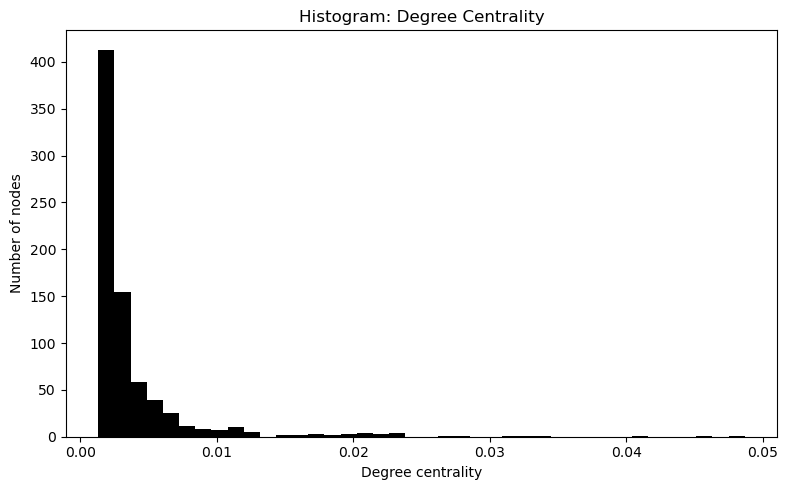

In [81]:
deg_cent = nx.degree_centrality(G)
deg_vals = np.array(list(deg_cent.values()), dtype=float)

plt.figure(figsize=(8,5))
plt.hist(deg_vals, bins=40,color="black")
plt.xlabel("Degree centrality")
plt.ylabel("Number of nodes")
plt.title("Histogram: Degree Centrality")
plt.tight_layout()
plt.show()

 * Degree Centrality Histogram

* The distribution is heavily right-skewed: most nodes have very small degree centrality, and a few hubs have much larger values.

* This matches the degree stats (median = 1, mean ≈ 2.7): a typical user connects to only a few others, while a small set of users connect to many.

* Implication: Information can spread widely if it reaches these hubs; the network is robust to random removals but vulnerable to targeted removal of hubs.

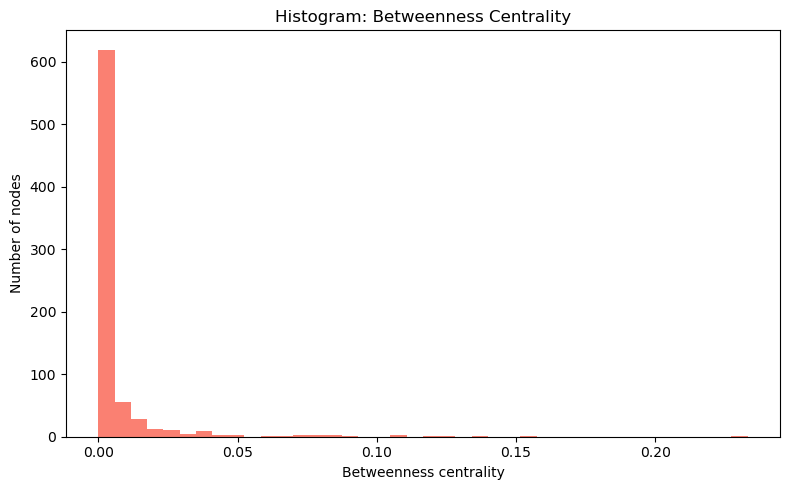

In [25]:
# Betweenness centrality 
bet_cent = nx.betweenness_centrality(G, normalized=True)
bet_vals = np.array(list(bet_cent.values()), dtype=float)

plt.figure(figsize=(8,5))
plt.hist(bet_vals, bins=40,color="salmon")
plt.xlabel("Betweenness centrality")
plt.ylabel("Number of nodes")
plt.title("Histogram: Betweenness Centrality")
plt.tight_layout()
plt.show()

* Betweenness Centrality Histogram

* Nearly all nodes have betweenness close to 0, with a thin tail of nodes at higher values.

* Only a small subset act as brokers/bridges, lying on many shortest paths between others.

* Implication: Those few high-betweenness nodes (e.g., 157, 136) are critical for connectivity and cross-community flow; removing them would increase distances or fragment the graph.

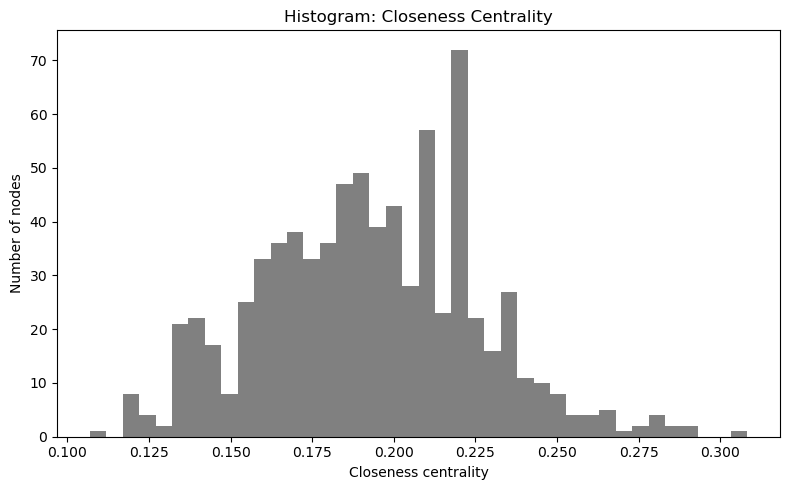

In [75]:
# Closeness centrality
close_cent = nx.closeness_centrality(G)
close_vals = np.array(list(close_cent.values()), dtype=float)

plt.figure(figsize=(8,5))
plt.hist(close_vals, bins=40,color="grey")
plt.xlabel("Closeness centrality")
plt.ylabel("Number of nodes")
plt.title("Histogram: Closeness Centrality")
plt.tight_layout()
plt.show()

* Closeness Centrality Histogram

* Values cluster around 0.20–0.23, with fewer nodes at the extremes.

* Many nodes are within a few hops of everyone else, reflecting the connected, small-world structure (ASPL = 5.35, diameter = 14).

* Implication: A sizeable core of nodes can reach the rest of the network relatively quickly, even though the network is sparse.

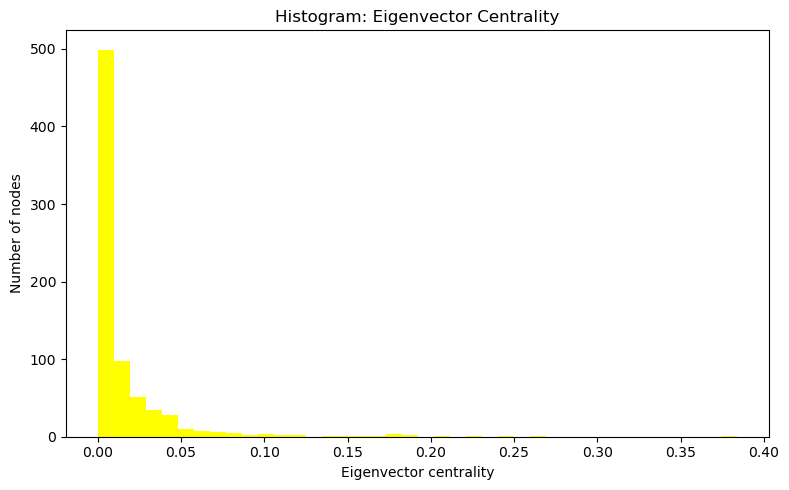

In [83]:
# Eigenvector centrality
try:
    eig_cent = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)
except nx.PowerIterationFailedConvergence:
    eig_cent = nx.eigenvector_centrality_numpy(G)
eig_vals = np.array(list(eig_cent.values()), dtype=float)

plt.figure(figsize=(8,5))
plt.hist(eig_vals, bins=40,color="yellow")
plt.xlabel("Eigenvector centrality")
plt.ylabel("Number of nodes")
plt.title("Histogram: Eigenvector Centrality")
plt.tight_layout()
plt.show()


* Eigenvector Centrality Histogram

* Strong right skew: the majority of nodes have very low eigenvector scores, while a very small set have high values.

* High-eigenvector nodes are not just well-connected; they are connected to other influential nodes (core-of-core).

* Implication: Influence is concentrated in a tight core; engaging those nodes can amplify reach disproportionately.

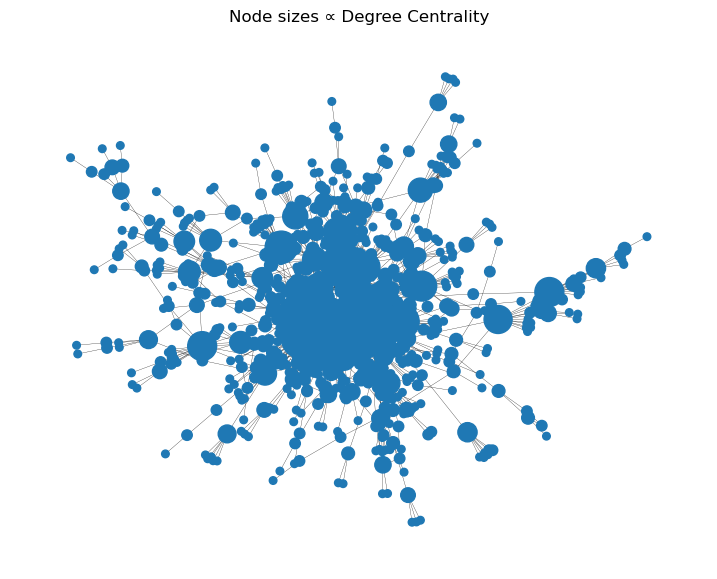

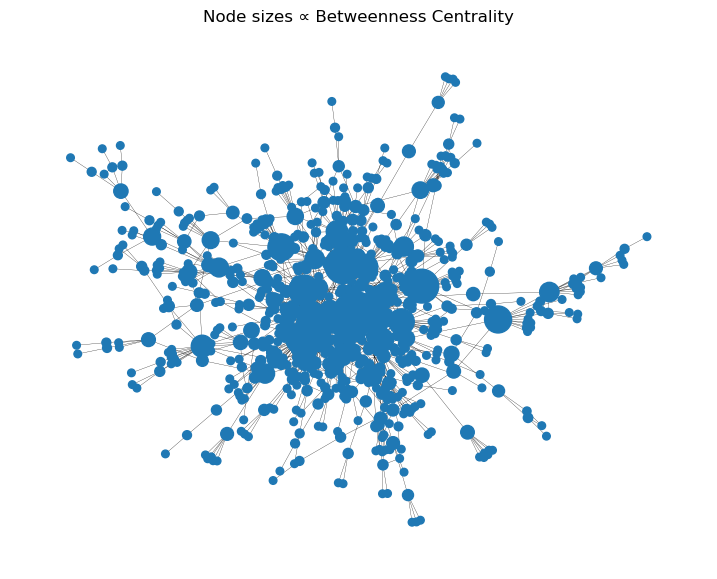

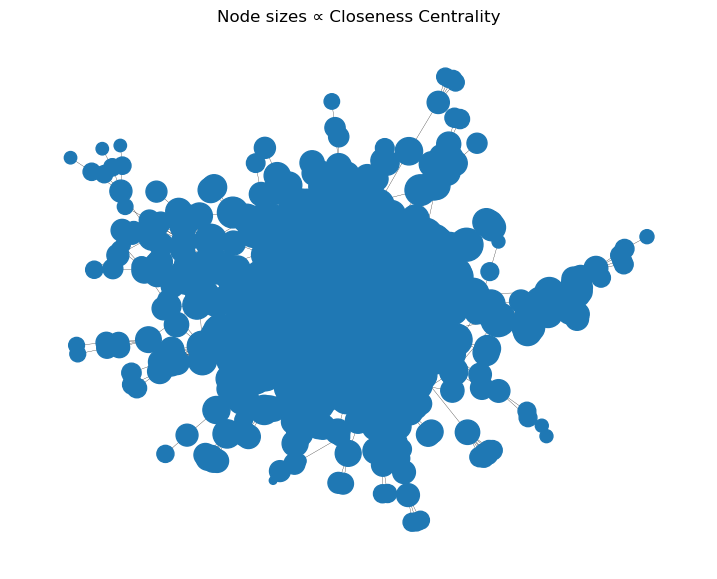

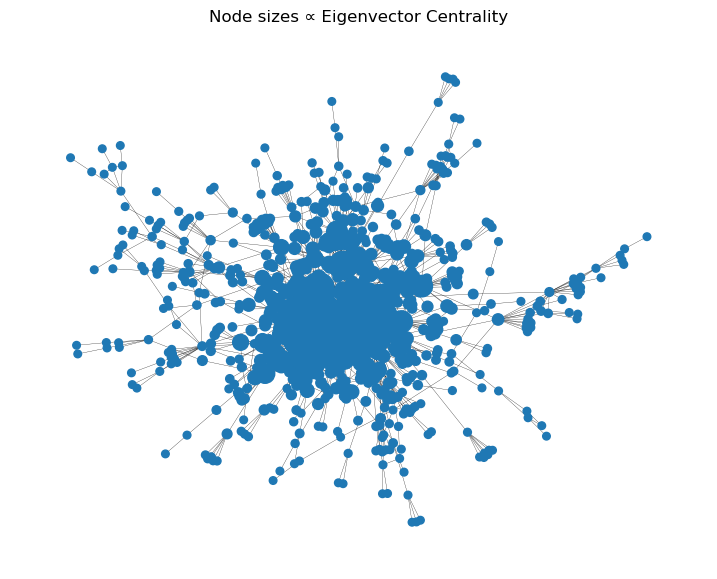

In [29]:
pos = nx.spring_layout(G, seed=7)

deg_cent = nx.degree_centrality(G)
bet_cent = nx.betweenness_centrality(G, normalized=True)  # exact
close_cent = nx.closeness_centrality(G)
try:
    eig_cent = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)
except nx.PowerIterationFailedConvergence:
    eig_cent = nx.eigenvector_centrality_numpy(G)

def scale_sizes(values_dict, min_size=30, max_size=1000):
    vals = np.array(list(values_dict.values()), dtype=float)
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        return np.array([min_size]*len(vals))
    # Min-max scale
    scaled = (vals - vmin) / (vmax - vmin)
    return (min_size + scaled * (max_size - min_size)).tolist()


sizes = scale_sizes(deg_cent)
plt.figure(figsize=(9,7))
nx.draw_networkx(G, pos, with_labels=False, node_size=sizes, width=0.2,)
plt.title("Node sizes ∝ Degree Centrality")
plt.axis("off")
plt.show()


sizes = scale_sizes(bet_cent)
plt.figure(figsize=(9,7))
nx.draw_networkx(G, pos, with_labels=False, node_size=sizes, width=0.2)
plt.title("Node sizes ∝ Betweenness Centrality")
plt.axis("off")
plt.show()

sizes = scale_sizes(close_cent)
plt.figure(figsize=(9,7))
nx.draw_networkx(G, pos, with_labels=False, node_size=sizes, width=0.2)
plt.title("Node sizes ∝ Closeness Centrality")
plt.axis("off")
plt.show()


sizes = scale_sizes(eig_cent)
plt.figure(figsize=(9,7))
nx.draw_networkx(G, pos, with_labels=False, node_size=sizes, width=0.2)
plt.title("Node sizes ∝ Eigenvector Centrality")
plt.axis("off")
plt.show()


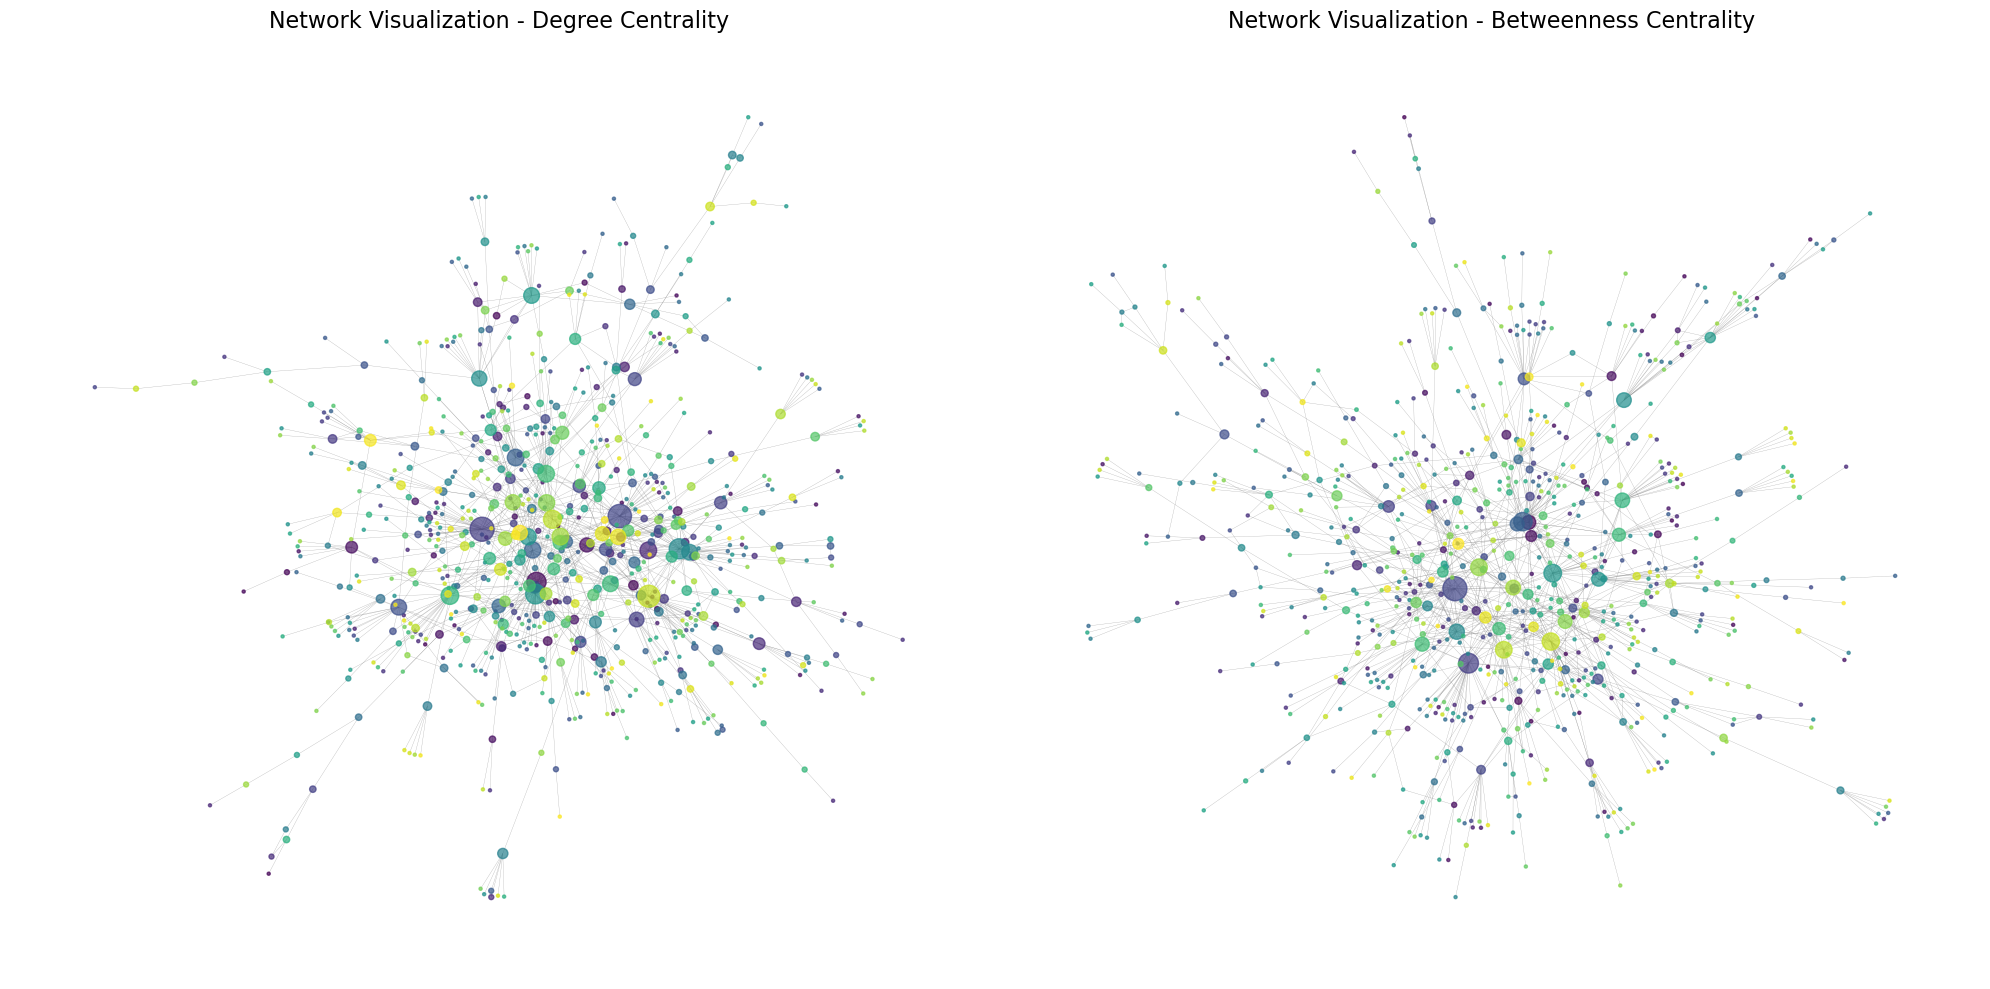

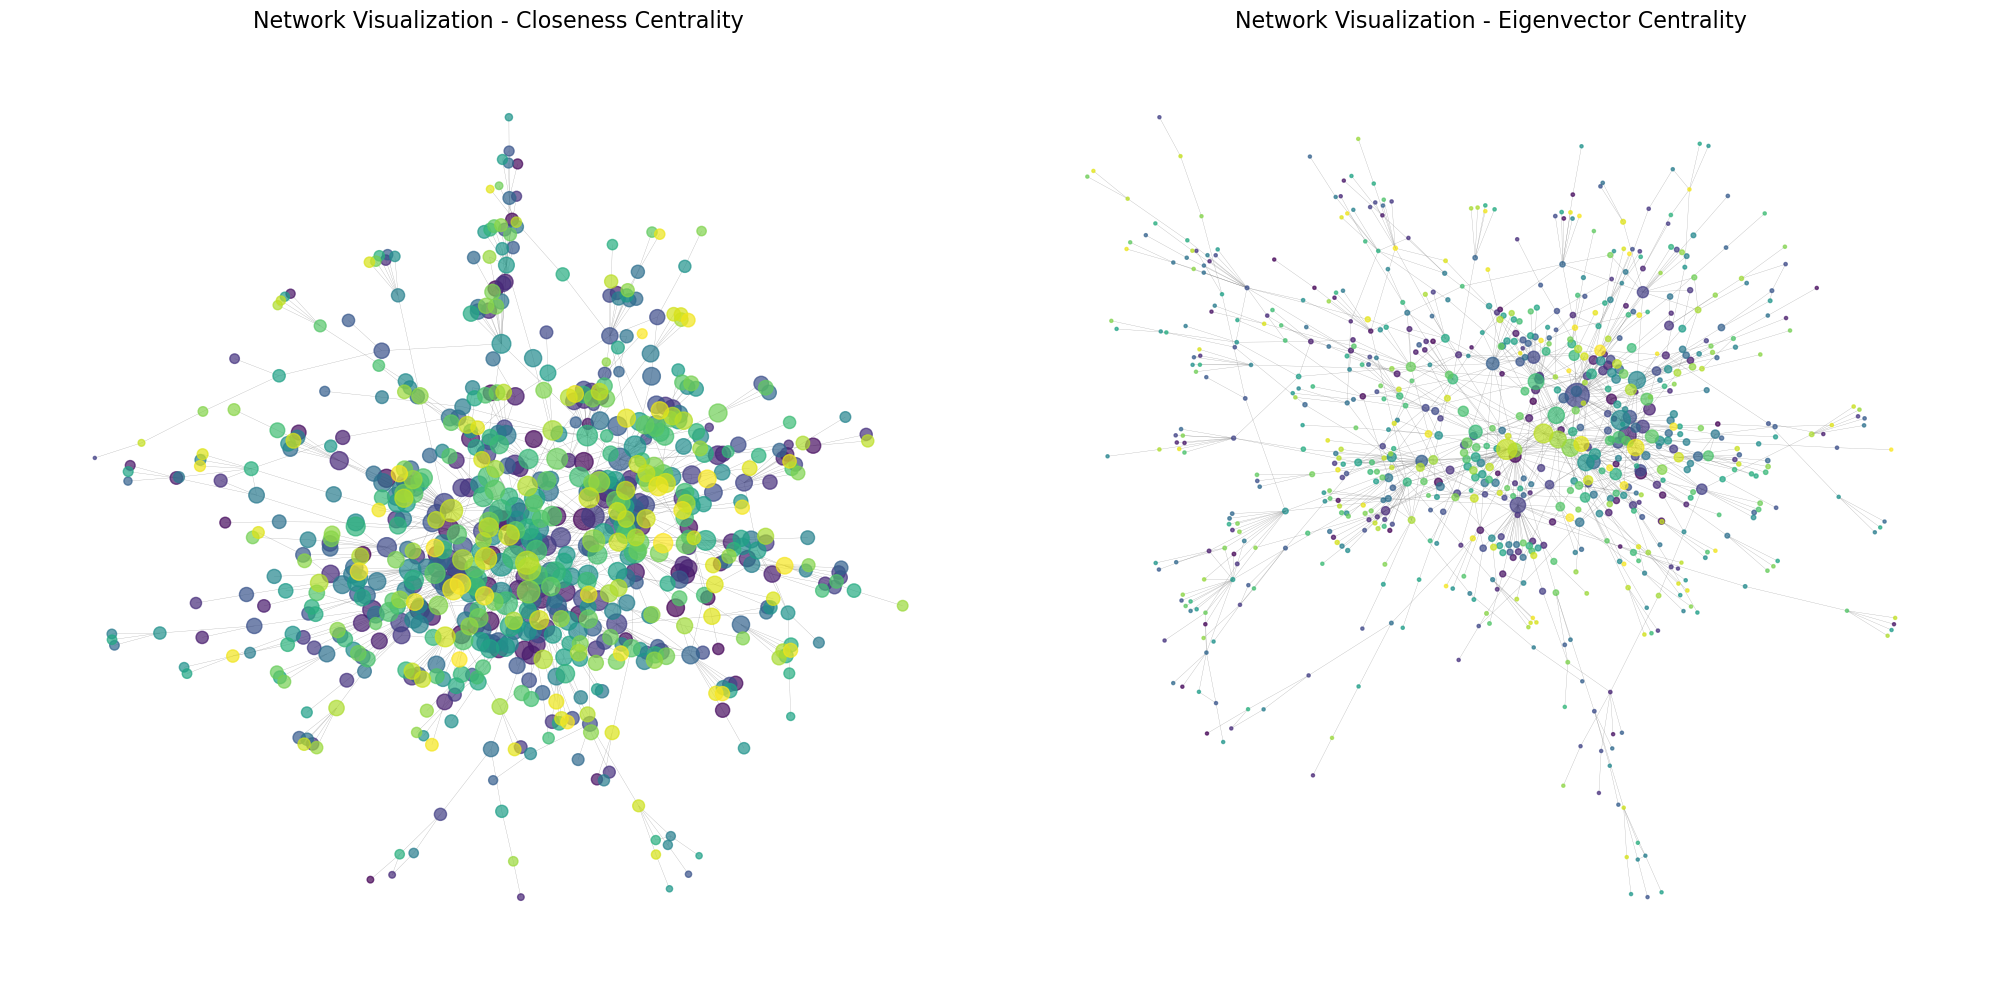

In [130]:
def normalize_sizes(values, min_size=5, max_size=300):
    if max(values) == min(values):
        return [min_size + (max_size - min_size)/2] * len(values)
    return [min_size + (max_size - min_size) * (x - min(values)) / (max(values) - min(values)) for x in values]


plt.figure(figsize=(20, 10))
node_colors = list(range(len(G)))

# Degree Centrality
plt.subplot(1, 2, 1)
node_sizes = [deg_cent[node] for node in G.nodes()]
node_sizes = normalize_sizes(node_sizes)

nx.draw(G, with_labels=False, node_size=node_sizes, 
        node_color=node_colors, 
        edge_color='gray', width=0.2, alpha=0.7)
plt.title("Network Visualization - Degree Centrality", fontsize=16)

# Betweenness Centrality
plt.subplot(1, 2, 2)
node_sizes = [bet_cent[node] for node in G.nodes()]
node_sizes = normalize_sizes(node_sizes)

nx.draw(G, with_labels=False, node_size=node_sizes, 
        node_color=node_colors, 
        edge_color='gray', width=0.2, alpha=0.7)
plt.title("Network Visualization - Betweenness Centrality", fontsize=16)

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
node_colors = list(range(len(G)))

largest_cc = max(nx.connected_components(G), key=len)
largest_cc = G.subgraph(largest_cc).copy()

# Closeness Centrality
plt.subplot(1, 2, 1)
# Filter nodes that are in the largest connected component
closeness_nodes = set(largest_cc.nodes())
node_sizes = [close_cent[node] if node in closeness_nodes else 0 for node in G.nodes()]
node_sizes = normalize_sizes(node_sizes)

nx.draw(G, with_labels=False, node_size=node_sizes, 
        node_color=node_colors,
        edge_color='gray', width=0.2, alpha=0.7)
plt.title("Network Visualization - Closeness Centrality", fontsize=16)

# Eigenvector Centrality
plt.subplot(1, 2, 2)
# Filter nodes that are in the largest connected component
eigenvector_nodes = set(largest_cc.nodes())
node_sizes = [eig_cent[node] if node in eigenvector_nodes else 0 for node in G.nodes()]
node_sizes = normalize_sizes(node_sizes)

nx.draw(G, with_labels=False, node_size=node_sizes, 
        node_color=node_colors,
        edge_color='gray', width=0.2, alpha=0.7)
plt.title("Network Visualization - Eigenvector Centrality", fontsize=16)

plt.tight_layout()
plt.show()